In [1]:
# 이미지분류 신경망
#LeNet-5 : 합성곱 신경망의 최초 구조
# 합성곱과 다운샘플링을 반복.. 마지막에 완전 연결층에서 분류 수행

In [2]:
# C1에서 5x5 합성곱 연산후 28x28크기의 특성맵 여섯개 생성
# S2에서 다운 샘플링 맵 크기를 14x14로 줄임
# C3는 5x5 합성곱 연산후 10x10크기의 특성맵 16 생성

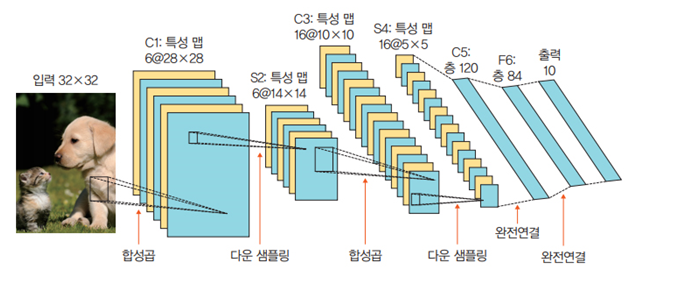

In [3]:
# LeNet-5를 사용하는 예제
# 데이터는 개 고양이

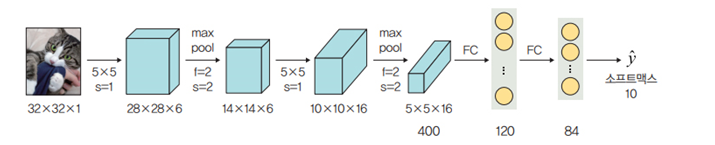

In [4]:
# 상세 설계안

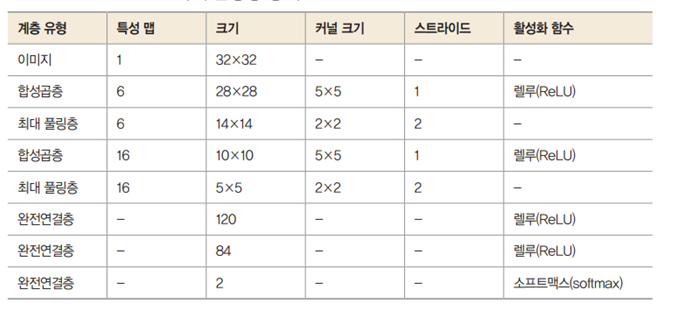

In [5]:
# 진행상황을 시각화 하기위해
!pip install --user tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#라이브러리 셋팅
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
import matplotlib.pyplot as plt


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# 데이터 전처리 - 텐서변환, 
class ImageTransform():
  def __init__(self,resize,mean,std) -> None:
    self.data_transform = {
        'train' : transforms.Compose(
            [
             transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),  # 이미지를 텐서형태로변경  픽셀의 범위가 0.0~1.0되고 차원은 (c,h,w)
             transforms.Normalize(mean,std) # 전이학습에서 사용되는 모델은 대부분 ImageNet데이터 셋에서 훈련, 데이터를 정규화
             # 주의점... ImageNet에서 이미지는 RGB채널 마다 평균과 표준편차를 의미
             # OpenCv를 이용해서 이미지를 읽어오면 RGB가 아니라 BGR 이미지이므로 채널 순서에 주의             
            ]
        ),
        'val': transforms.Compose(
            [
             transforms.Resize(256),
             transforms.CenterCrop(resize),
             transforms.ToTensor(),
             transforms.Normalize(mean,std)             
            ]
        )
    }
  def __call__(self, img,phase):   # 클래스를 호출할 수 있도록 하는 메서드  객체가 호출되었을때 실행되는 메서드
    return self.data_transform[phase](img)

In [9]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()

Saving catanddog.zip to catanddog.zip


In [10]:
!unzip catanddog.zip -d dogs-vs-cats/

Archive:  catanddog.zip
   creating: dogs-vs-cats/test/
   creating: dogs-vs-cats/test/Cat/
  inflating: dogs-vs-cats/test/Cat/8100.jpg  
  inflating: dogs-vs-cats/test/Cat/8101.jpg  
  inflating: dogs-vs-cats/test/Cat/8102.jpg  
  inflating: dogs-vs-cats/test/Cat/8103.jpg  
  inflating: dogs-vs-cats/test/Cat/8104.jpg  
  inflating: dogs-vs-cats/test/Cat/8105.jpg  
  inflating: dogs-vs-cats/test/Cat/8106.jpg  
  inflating: dogs-vs-cats/test/Cat/8107.jpg  
  inflating: dogs-vs-cats/test/Cat/8108.jpg  
  inflating: dogs-vs-cats/test/Cat/8109.jpg  
  inflating: dogs-vs-cats/test/Cat/8110.jpg  
  inflating: dogs-vs-cats/test/Cat/8111.jpg  
  inflating: dogs-vs-cats/test/Cat/8112.jpg  
  inflating: dogs-vs-cats/test/Cat/8113.jpg  
  inflating: dogs-vs-cats/test/Cat/8114.jpg  
  inflating: dogs-vs-cats/test/Cat/8115.jpg  
  inflating: dogs-vs-cats/test/Cat/8116.jpg  
  inflating: dogs-vs-cats/test/Cat/8117.jpg  
  inflating: dogs-vs-cats/test/Cat/8118.jpg  
  inflating: dogs-vs-cats/test/Cat

In [11]:
cat_directory = 'dogs-vs-cats/train/Cat'
dog_directory = 'dogs-vs-cats/train/Dog'

In [12]:
from glob import glob

In [13]:
cat_images_filepaths = sorted(glob(cat_directory+"/*.jpg"))
dog_images_filepaths = sorted(glob(dog_directory+"/*.jpg"))

In [14]:
images_filepaths = [*cat_images_filepaths,*dog_images_filepaths]  # len(cat_images_filepaths+dog_images_filepaths)

In [15]:
# 이미지경로에 있는 이미지가 실제 이미지 인지 확인
correct_images_filepath = [i for i in images_filepaths if cv2.imread(i) is not None]

In [16]:
len(correct_images_filepath)

385

In [21]:
random.seed(42)
random.shuffle(correct_images_filepath)
#훈련용 데이터, 검증용 데이터 8:2로 분할
split_size = int(len(correct_images_filepath) * 0.8)

train_images_filepaths = correct_images_filepath[:split_size]
val_images_filepaths = correct_images_filepath[split_size:-10]
test_images_filepaths = correct_images_filepath[-10:]
len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths)

(308, 67, 10)

In [22]:
# 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
  rows = len(images_filepaths) // cols
  figure,ax =  plt.subplots(nrows = rows, ncols = cols, figsize=(12,6))
  for i,imagepath in enumerate(images_filepaths):
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)  #  BGR -- >RGB
    true_label = os.path.normpath(imagepath).split(os.sep)[-2]
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = 'green' if true_label == predicted_label else 'red'
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(predicted_label,color=color)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout() # 이미지 여백조정
  plt.show()



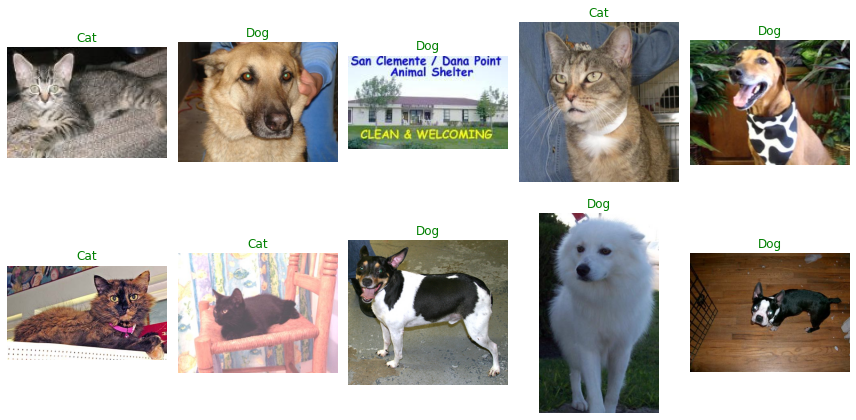

In [23]:
display_image_grid(test_images_filepaths)

In [24]:
# 데이터 준비가 완료
# init에서 한꺼번에 가져오지 않고 경로를 지정하면 batch size 만큼 잘라서 가져올수 있도록 구성

In [31]:
# 데이터 셋의 역활을 하도록 Dataset 클래스를 상속받아서 클래스를 작성
class DogvsCatDataSet(Dataset):
  def __init__(self, file_list, transeform=None,phase='train') -> None:
    self.file_list = file_list
    self.transform = transeform
    self.phase = phase
  def __len__(self):
    return len(self.file_list)
  # 데이터  셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태
  def __getitem__(self, idx):
    img_path = self.file_list[idx]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)  # 이미지에 train 전처리를 적용
    label = img_path.split('/')[-2].lower()
    # dogs-vs-cats/train/Dog/983.jpg  
    if label == 'dog':
      label = 1
    elif label == 'cat':
      label = 0
    return img_transformed, label  


In [32]:
size=224
batch_size = 32
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)

In [33]:
train_images_filepaths[0]

'dogs-vs-cats/train/Dog/1055.jpg'

In [34]:
train_dataset = DogvsCatDataSet(train_images_filepaths
                                , transeform=ImageTransform(size,mean,std),phase='train')
val_dataset = DogvsCatDataSet(train_images_filepaths
                                , transeform=ImageTransform(size,mean,std),phase='val')


In [39]:
train_dataset.__getitem__(0)[0].size(), train_dataset.__getitem__(0)[1] 

(torch.Size([3, 224, 224]), 1)

In [40]:
# 전처리, 데이터셋을 정의
# 메모리로 불러와서 훈련을위한 준비
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train' : train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label =  next(batch_iterator)
inputs.size(), label

(torch.Size([32, 3, 224, 224]),
 tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         1, 1, 0, 1, 0, 0, 1, 1]))

In [43]:
# 이미지 분류를 위한 신경망
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
  # 입력형태는 3,224,224  출력은 커널사이즈 5 스트라이드 1
  # (weight-kernel_size+1)/stride  (224-5+1)/1  (out_channel, 220,220)
    self.cnn1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=0)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # 220/2  110  (16,110,110)
    self.cnn2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=0)  # (32,106,106)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # (32,53,53)


    self.fc1 = nn.Linear(32*53*53,512)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(512,2)
    self.output = nn.Softmax(dim=1)
  def forward(self,x):
    out = self.cnn1(x);
    out = self.relu1(out);
    out = self.maxpool1(out);
    out = self.cnn2(out);
    out = self.relu2(out);
    out = self.maxpool2(out);
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.output(out)
    return out

In [44]:
model = LeNet().to(device)

In [46]:
model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)

In [47]:
# 네트워크의 각 부분들은 통과할 때마다 입력과 출력의 형태가 바뀜
# Conv2d 출력 크기 구하는 공식

# 출력크기 = (W-F+2P)/2+1
# W : 입력데이터의 크기
# F : 커널 크기
# P : 패딩 크기
# S : 스트라이드

# MaxPool2d 계층의 출력크기 공식
# IF/F
# IF : 입력필터의 크기
# F : 커널크기

In [ ]:
#합성곱층과 폴링층의 크기계산

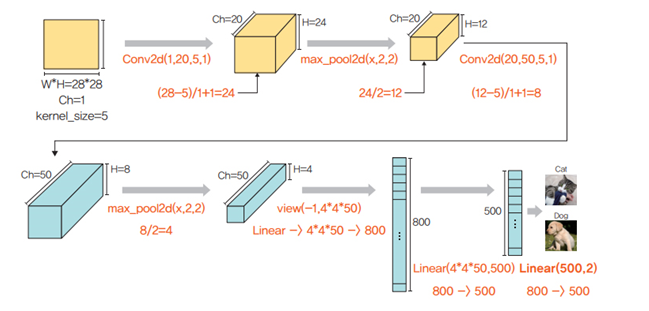

In [48]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------